<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-train-dataset" data-toc-modified-id="Load-train-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load train dataset</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Version-4---resize-des-images,-en-ne-gardant-que-les-bbox-et-category_id-des-targets-normalisées,-dans-un-array-de-dictionnaires-(targets-de-taille-variables)" data-toc-modified-id="Version-4---resize-des-images,-en-ne-gardant-que-les-bbox-et-category_id-des-targets-normalisées,-dans-un-array-de-dictionnaires-(targets-de-taille-variables)-1.0.0.1"><span class="toc-item-num">1.0.0.1&nbsp;&nbsp;</span>Version 4 - resize des images, en ne gardant que les bbox et category_id des targets normalisées, dans un array de dictionnaires (targets de taille variables)</a></span></li></ul></li></ul></li></ul></li></ul></div>

This notebook aims to provide functions that produce anchor boxes as decribed in the paper.

A box will be describe either as a numpy array $[y^-, x^-, y^+, x^+]$  or as a numpy array $[c_y, c_x, h,w]$

TODO : CHECK +1

In [ ]:
!pip install pycocotools
!pip install engine

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches #In order to draw the box ! (je sais pas pourquoi j'écris en anglais)
from torchvision import models
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torchvision
import pycocotools
import copy
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

CUDA_LAUNCH_BLOCKING=1.

In [2]:
# The directory containing the source images
data_path = "dataset/instance_version/train"
valid_path = "dataset/instance_version/val"
# The path to the COCO labels JSON file
labels_path = "dataset/instance_version/instances_train_trashcan.json"
labels_test = "dataset/instance_version/instances_val_trashcan.json"

# Load train dataset 

J'ai réussi à utiliser l'API Coco via `torchvision.datasets.CocoDetection` (https://pytorch.org/vision/stable/datasets.html)


In [15]:
#Permet d'utiliser la co des serveurs Google (rip la mienne) et assure une meilleure reproductibilité
!wget "https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y"
!unzip "dataset.zip?sequence=12&isAllowed=y"

--2022-02-01 21:55:11--  https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y
Resolving conservancy.umn.edu (conservancy.umn.edu)... 128.101.122.105
Connecting to conservancy.umn.edu (conservancy.umn.edu)|128.101.122.105|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 553029970 (527M) [application/zip]
Saving to: ‘dataset.zip?sequence=12&isAllowed=y.3’

uence=12&isAllowed=  13%[=>                  ]  71.20M  16.6MB/s    eta 43s    ^C
Archive:  dataset.zip?sequence=12&isAllowed=y
replace dataset/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [4]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
image_torch = 800*torch.rand((1,3,800,800))
#We choose the place where we extracted the feature map in order to get H_feature * W_feature around 2400 (papers)
resnet50_features = nn.Sequential(*(list(resnet50.children())[:-3]))
resnet50_features(image_torch).shape

torch.Size([1, 1024, 50, 50])

#### Version 4 - resize des images, en ne gardant que les bbox et category_id des targets normalisées, dans un array de dictionnaires (targets de taille variables)

In [5]:
#Attention "bbox": [x,y,width,height]
class CocoDetection_diy_bis(data.Dataset) :
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        resize : (int,int) size of the images wanted 
    """

    def __init__(self, root, annFile, size):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.total_ids = list(self.coco.imgs.keys())
        self.ids = [self.total_ids[j] for j in range(len(self.total_ids))]
        self.size = size
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        # Resize des images :
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        original_size = img.size
        img = self.transform(img)

        # Targets dict :
        targets = {'labels':[],'boxes':[], 'area':[]}

        for elem in target :  
          box = np.copy(elem['bbox'])
          box[0] *= self.size[0] / original_size[0]
          box[1] *= self.size[1] / original_size[1]
          box[2] *= self.size[0] / original_size[0]
          box[3] *= self.size[1] / original_size[1]
          
          new_box = np.copy(elem['bbox'])
          new_box[0] = box[0]
          new_box[1] = box[1] 
          new_box[2] = box[0] + (box[2])
          new_box[3] = box[1] + (box[3])
          area_computed = (new_box[3] - new_box[1])*(new_box[2] - new_box[0])
          targets['boxes'].append(new_box)
          targets['area'].append(area_computed)
        #  targets['labels'].append(elem['category_id'] + 1) # +1 because 0 will be for background
        #targets['labels'] = torch.from_numpy(np.array(targets["labels"]))
        targets['labels'] = torch.ones(len(targets['area'])).to(torch.int64) 
        targets["iscrowd"] = torch.zeros(len(targets['area']))
        targets['area'] = torch.from_numpy(np.array(targets["area"]))
        if(len(targets["boxes"]) > 0):
            targets["boxes"] = torch.from_numpy(np.vstack(targets["boxes"]))
        else:
            targets["boxes"] = torch.Tensor([])
        
        return img, targets
        


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))


TODO : que faire lorsqu'on a des images sans box et sans label donc ?

In [7]:
instances_train = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224))
instances_train_dataloader = DataLoader(instances_train, batch_size=4, shuffle=True,collate_fn = collate_fn)

instances_valid = CocoDetection_diy_bis(root = valid_path, annFile = labels_test, size=(224,224))
instances_valid_dataloader = DataLoader(instances_valid, batch_size=4, shuffle=True,collate_fn = collate_fn)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [8]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = resnet50_features

backbone.out_channels = 1024


anchor_generator = AnchorGenerator(sizes=((4,8,16,32,64),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))


roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes= 2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [9]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

from torch import optim
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

In [10]:
total_train_loss = []
total_val_loss = []

N_EPOCH = 30
for epoch in range(N_EPOCH):
    train_loss = []
    val_loss = []
    model.train()
    for images, targets in instances_train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        ind_to_remove = [i for i in range(len(targets)) if targets[i]["labels"].shape == torch.Size([0])]
        #memove when empty
        images = [images[i] for i in range(len(images)) if not(i in ind_to_remove)]
        targets = [targets[i] for i in range(len(targets)) if not(i in ind_to_remove)]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    with torch.no_grad():
        for images, targets in instances_valid_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            ind_to_remove = [i for i in range(len(targets)) if targets[i]["labels"].shape == torch.Size([0])]
            #memove when empty
            images = [images[i] for i in range(len(images)) if not(i in ind_to_remove)]
            targets = [targets[i] for i in range(len(targets)) if not(i in ind_to_remove)]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss.append(losses.item())
    epoch_val_loss = np.mean(val_loss)
    total_val_loss.append(epoch_val_loss)
    if(epoch_val_loss == min(total_val_loss)):
        best_model = copy.deepcopy(model.state_dict())

/usr/local/lib/python3.6/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
eval = np.vstack([np.array(total_train_loss),np.array(total_val_loss)])

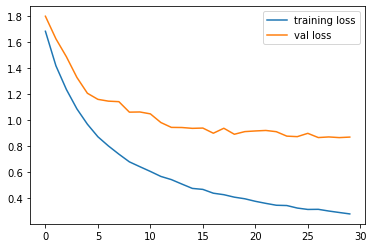

In [24]:
plt.plot(range(len(eval[0,:])), eval[0,:], label = "training loss"),
plt.plot(range(len(eval[0,:])), eval[1,:], label = "val loss"),
plt.legend()

In [12]:
torch.save(best_model, "model2_sans_data_augmentation.pt")

In [25]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = resnet50_features

backbone.out_channels = 1024


anchor_generator = AnchorGenerator(sizes=((4,8,16,32,64),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))


roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model2 = FasterRCNN(backbone,
                   num_classes= 2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [31]:
model2.load_state_dict(best_model)

<All keys matched successfully>

In [32]:
model2.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [34]:
def pictures_and_boxes(image_tensor, boxes, size):
    trans = transforms.Compose([transforms.Resize(size), transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)])
    img = transforms.functional.to_pil_image(trans(image_tensor.squeeze()))
    #draw = ImageDraw.Draw(img)
    fig, ax = plt.subplots()
    plt.imshow(img)
    for box in boxes.tolist():
        #box = correction(box)
        #rect = patches.Rectangle((box[0],box[1]) , box[2] , box[3], linewidth=1, edgecolor='r', facecolor='none')
        rect = patches.Rectangle((box[0],box[1]) , (box[2] - box[0]) ,(box[3] - box[1]), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    return(img)

In [48]:
device = "cpu"

In [50]:
images,targets = next(iter(instances_valid_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
ind_to_remove = [i for i in range(len(targets)) if targets[i]["labels"].shape == torch.Size([0])]
#memove when empty
images = [images[i] for i in range(len(images)) if not(i in ind_to_remove)]
targets = [targets[i] for i in range(len(targets)) if not(i in ind_to_remove)]


In [51]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [52]:
pred = model(images)

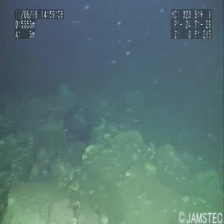

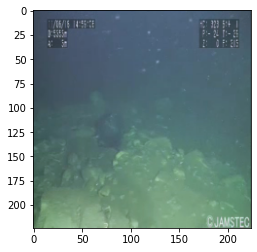

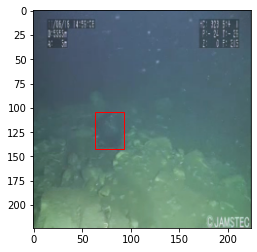

In [62]:
i = 1
pictures_and_boxes(images[i], pred[i]["boxes"], (224,224))
pictures_and_boxes(images[i], targets[i]["boxes"], (224,224))